In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from geopy.distance import geodesic

In [2]:
# Load the datasets
customers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
receipt_lines_df = pd.read_csv('receipt_lines.csv')
receipts_df = pd.read_csv('receipts.csv')
stores_df = pd.read_csv('stores.csv')

In [3]:
# Define the cutoff date
latest_purchase_date = receipts_df['purchased_at'].max()
cutoff_date = datetime.strptime(latest_purchase_date, '%Y-%m-%d') - timedelta(days=90)

# Convert the 'purchased_at' column to a datetime object
receipts_df['purchased_at'] = pd.to_datetime(receipts_df['purchased_at'])

# Determine the set of customers who made a purchase after the cutoff date
churned_customers = set(receipts_df.loc[receipts_df['purchased_at'] > cutoff_date, 'customer_id'].unique())

# Calculate the percentage of customers who churned
days = 90
churn_definition = cutoff_date - timedelta(days=days)
total_customers = customers_df['customer_id'].nunique()
churned_count = receipts_df.loc[receipts_df['purchased_at'] <= churn_definition, 'customer_id'].nunique()
churn_rate = churned_count / total_customers
churned_percent = churned_count / total_customers * 100

print(f"{churned_percent}% of customers churned")

beta = churn_rate / days
print(f" Beta: {beta}")

83.67299133286484% of customers churned
 Beta: 0.009296999036984983


In [4]:
# Check for missing values in each table
print("Missing values in Customers:")
print(customers_df.isnull().sum())

print("Missing values in Products:")
print(products_df.isnull().sum())

print("Missing values in Receipt Lines:")
print(receipt_lines_df.isnull().sum())

print("Missing values in Receipts:")
print(receipts_df.isnull().sum())

print("Missing values in Stores:")
print(stores_df.isnull().sum())

# Handle missing values
#customers.dropna(inplace=True)
products_df.dropna(inplace=True)
receipt_lines_df.dropna(inplace=True)
receipts_df.dropna(inplace=True)
stores_df.dropna(inplace=True)

# Load the receipts data
receipts = pd.read_csv('receipts.csv')

# Convert the purchased_at column to a datetime object
receipts['purchased_at'] = pd.to_datetime(receipts['purchased_at'])

# Calculate the last purchase date for each customer
last_purchase_date = receipts.groupby('customer_id')['purchased_at'].max()

# Define the cutoff date for churn (e.g. 3 months ago)
cutoff_date = datetime.strptime('2021-12-22', '%Y-%m-%d')

# Label customers as churned or not based on their last purchase date
churned_customers = last_purchase_date[last_purchase_date < cutoff_date].index

# Load the customers data
customers = pd.read_csv('customers.csv')

# Add a new column to the customers data indicating whether they have churned or not
customers['churned'] = customers['customer_id'].isin(churned_customers).astype(int)

# Output the labeled customers data
print(customers.head())

# Count the number of churned customers
churned_customers = customers[customers['churned'] == 1]
print(churned_customers['churned'].value_counts())

# Check for duplicates in Customers table
duplicates_customers = customers.duplicated(subset=['customer_id']).sum()
if duplicates_customers > 0:
    print(f'{duplicates_customers} duplicates found in Customers table')
else:
    print('No duplicates found in Customers table')

# Check for duplicates in Products table
duplicates_products = products_df.duplicated(subset=['product_code']).sum()
if duplicates_products > 0:
    print(f'{duplicates_products} duplicates found in Products table')
else:
    print('No duplicates found in Products table')

# Check for duplicates in Receipt_Lines table
duplicates_receipt_lines = receipt_lines_df.duplicated(subset=['receipt_line_id']).sum()
if duplicates_receipt_lines > 0:
    print(f'{duplicates_receipt_lines} duplicates found in Receipt_Lines table')
else:
    print('No duplicates found in Receipt_Lines table')

# Check for duplicates in Receipts table
duplicates_receipts = receipts.duplicated(subset=['receipt_id']).sum()
if duplicates_receipts > 0:
    print(f'{duplicates_receipts} duplicates found in Receipts table')
else:
    print('No duplicates found in Receipts table')

# Check for duplicates in Stores table
duplicates_stores = stores_df.duplicated(subset=['store_code']).sum()
if duplicates_stores > 0:
    print(f'{duplicates_stores} duplicates found in Stores table')
else:
    print('No duplicates found in Stores table')


# Check consistency between customers and receipts tables
customers_with_receipts = receipts.customer_id.unique()
customers_in_db = customers.customer_id.unique()

if not set(customers_with_receipts).issubset(set(customers_in_db)):
    print("Error: Inconsistent data - some customers in the receipts table don't exist in the customers table.")

# Check consistency between stores and receipts tables
stores_with_receipts = receipts.store_code.unique()
stores_in_db = stores_df.store_code.unique()

if not set(stores_with_receipts).issubset(set(stores_in_db)):
    print("Error: Inconsistent data - some stores in the receipts table don't exist in the stores table.")

# Check consistency between receipts and receipt_lines tables
receipts_with_lines = receipt_lines_df.receipt_id.unique()
receipts_in_db = receipts.receipt_id.unique()

if not set(receipts_with_lines).issubset(set(receipts_in_db)):
    print("Error: Inconsistent data - some receipts in the receipt_lines table don't exist in the receipts table.")

# Check consistency between products and receipt_lines tables
products_with_receipt_lines = receipt_lines_df.product_code.unique()
products_in_db = products_df.product_code.unique()

if not set(products_with_receipt_lines).issubset(set(products_in_db)):
    print("Error: Inconsistent data - some products in the receipt_lines table don't exist in the products table.")

Missing values in Customers:
customer_id       0
first          3719
last              0
dob            3718
dtype: int64
Missing values in Products:
product_code            0
product_details         0
department_code         0
department_name         0
category_code           0
category_details        0
sub_category_code       0
sub_category_details    0
dtype: int64
Missing values in Receipt Lines:
receipt_line_id    0
receipt_id         0
product_code       0
qty                0
value              0
dtype: int64
Missing values in Receipts:
receipt_id      0
purchased_at    0
customer_id     0
store_code      0
till_number     0
dtype: int64
Missing values in Stores:
store_code    0
address       0
postcode      0
lat           0
lng           0
dtype: int64
   customer_id first     last  dob  churned
0            6   NaN   Bryant  NaN        0
1            8   NaN  Beabout  NaN        1
2            9   NaN    Ellis  NaN        1
3           20   NaN     Doss  NaN        1
4       

In [5]:
df = pd.merge(customers, receipts, on='customer_id')
df = pd.merge(df, receipt_lines_df, on='receipt_id')
df = pd.merge(df, stores_df, on='store_code')
df = pd.merge(df, products_df, on='product_code')

In [6]:
print(df.dtypes)

customer_id                      int64
first                           object
last                            object
dob                             object
churned                          int64
receipt_id                       int64
purchased_at            datetime64[ns]
store_code                       int64
till_number                      int64
receipt_line_id                  int64
product_code                     int64
qty                              int64
value                          float64
address                         object
postcode                        object
lat                            float64
lng                            float64
product_details                 object
department_code                  int64
department_name                 object
category_code                    int64
category_details                object
sub_category_code                int64
sub_category_details            object
dtype: object


In [7]:
# Convert dob column to datetime format
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d', errors='coerce')

# Calculate age from dob
now = pd.Timestamp('now')
df['age'] = (now - df['dob']).astype('<m8[Y]')

# Create a column for the total value of each receipt
df['receipt_total'] = df['qty'] * df['value']
# Calculate average value per purchase
df['avg_purchase_value'] = df['receipt_total'] / df['qty']
churned_df = df[df['churned'] == 1]
churned_df = churned_df.copy()
churned_df['avg_purchase_value'] = churned_df['receipt_total'] / churned_df['qty']
# Create a column for the number of days since the customer's last purchase
df['days_since_last_purchase'] = (df['purchased_at'].max() - df.groupby('customer_id')['purchased_at'].max()).dt.days
# Convert days_since_last_purchase to months
df['months_since_last_purchase'] = df['days_since_last_purchase'] / 30

# Create a column for the total number of purchases in the past 3 months
df['num_purchases_3mo'] = df.loc[df['purchased_at'] >= cutoff_date].groupby('customer_id')['receipt_id'].nunique()
# Calculate average monthly purchase frequency
df['monthly_purchase_frequency'] = df['num_purchases_3mo'] / 3

# Count unique category codes and sub-category codes for each customer and store
df.reset_index(drop=True, inplace=True)
# Convert category_code and sub_category_code to strings
df['category_code'] = df['category_code'].astype(str)
df['sub_category_code'] = df['sub_category_code'].astype(str)


# Extract month and year from purchased_at
df['month'] = df['purchased_at'].dt.month
df['year'] = df['purchased_at'].dt.year

# Calculate number of visits and visit share for each customer at each store
df['num_visits'] = df.groupby(['customer_id', 'store_code'])['receipt_id'].transform('count')
df['visit_share'] = df['num_visits'] / df.groupby(['customer_id'])['num_visits'].transform('sum')


In [8]:
print(df.columns)

Index(['customer_id', 'first', 'last', 'dob', 'churned', 'receipt_id',
       'purchased_at', 'store_code', 'till_number', 'receipt_line_id',
       'product_code', 'qty', 'value', 'address', 'postcode', 'lat', 'lng',
       'product_details', 'department_code', 'department_name',
       'category_code', 'category_details', 'sub_category_code',
       'sub_category_details', 'age', 'receipt_total', 'avg_purchase_value',
       'days_since_last_purchase', 'months_since_last_purchase',
       'num_purchases_3mo', 'monthly_purchase_frequency', 'month', 'year',
       'num_visits', 'visit_share'],
      dtype='object')


store_code
0    0.365454
1    0.181546
2    0.306417
3    0.365237
Name: churned, dtype: float64


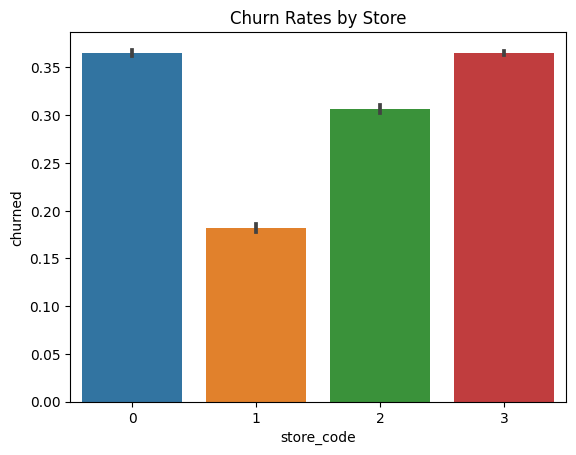

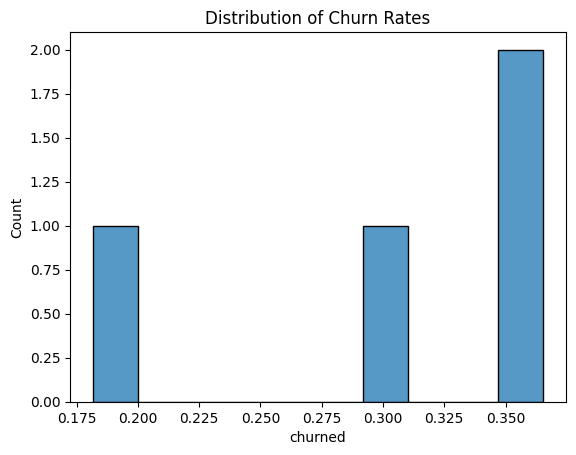

<ipython-input-9-9914c2a127d9>:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


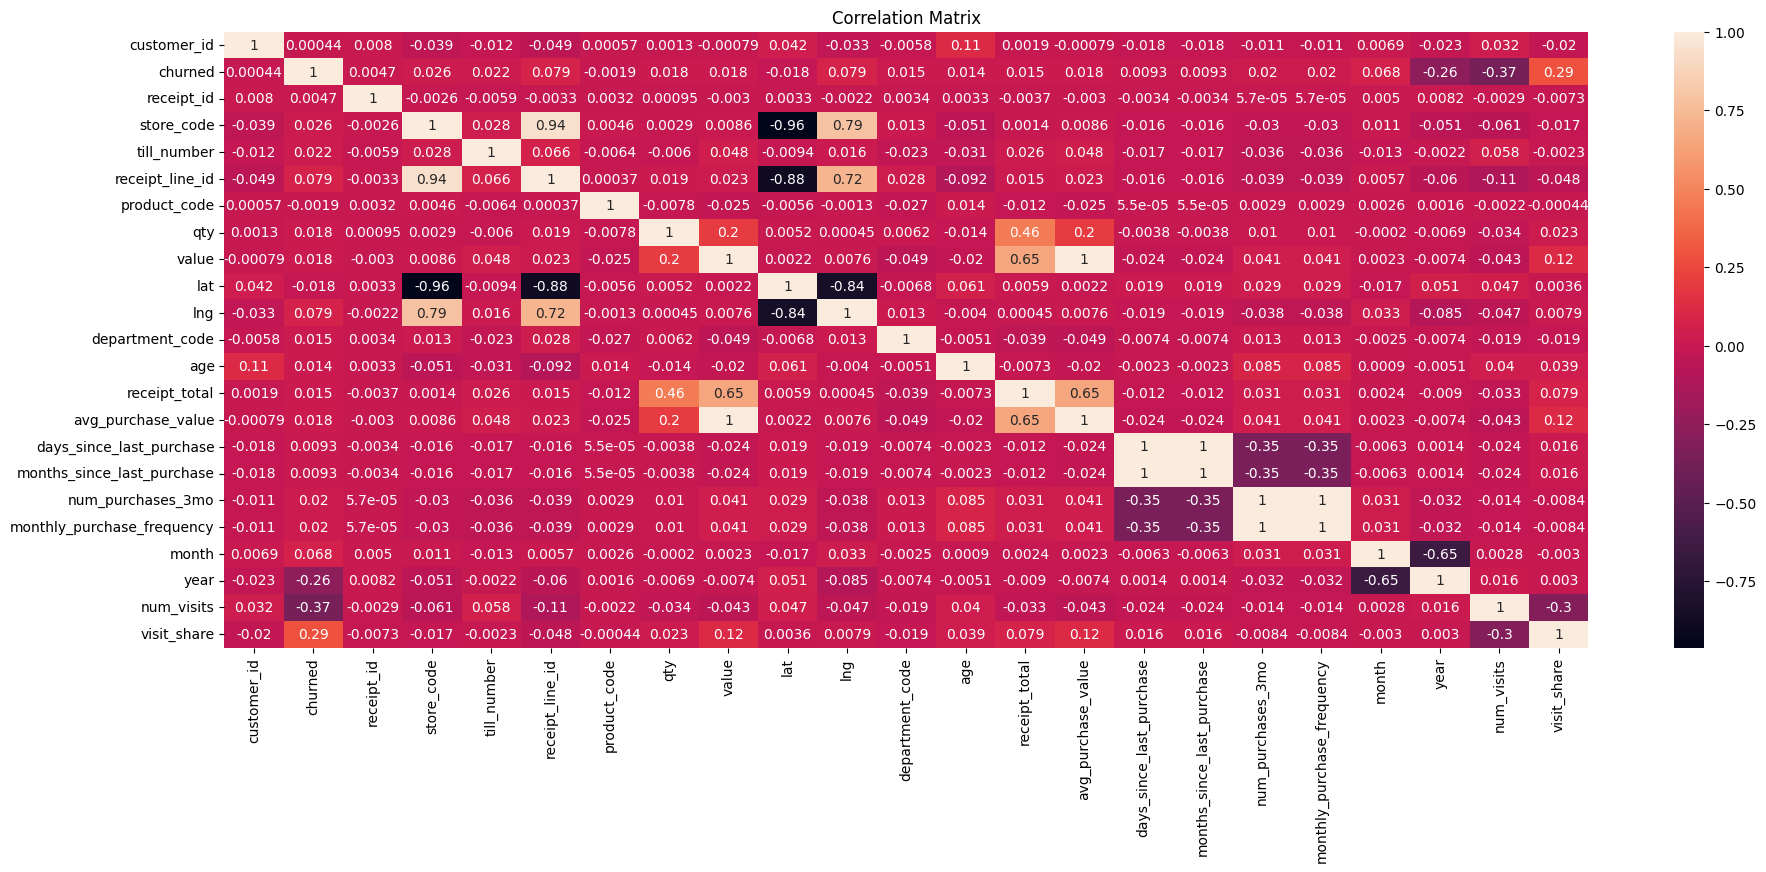

In [9]:
# Calculate the churn rates for each store
churn_rates = df.groupby('store_code')['churned'].mean()

# Print the churn rates for each store
print(churn_rates)

# Churn rates using a bar plot
sns.barplot(x='store_code', y='churned', data=df)
plt.title('Churn Rates by Store')
plt.show()

# Distribution of churn rates using a histogram
sns.histplot(churn_rates, bins=10)
plt.title('Distribution of Churn Rates')
plt.show()

# A correlation matrix to identify any relationships between variables
corr_matrix = df.corr()
plt.figure(figsize=(22,8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()


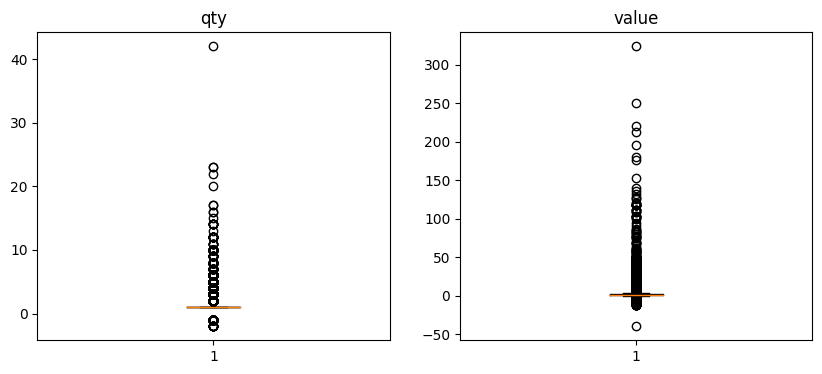

count    303289.000000
mean          1.203357
std           0.595759
min          -2.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          42.000000
Name: qty, dtype: float64
count    303289.000000
mean          1.630444
std           2.801401
min         -40.000000
25%           0.690000
50%           1.050000
75%           1.750000
max         324.000000
Name: value, dtype: float64


In [10]:
# Load the receipt_lines data
receipt_lines = pd.read_csv('receipt_lines.csv')

# Check for outliers in the qty and value columns
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].boxplot(receipt_lines['qty'])
axs[0].set_title('qty')
axs[1].boxplot(receipt_lines['value'])
axs[1].set_title('value')
plt.show()

# Check the descriptive statistics for qty and value
print(receipt_lines['qty'].describe())
print(receipt_lines['value'].describe())

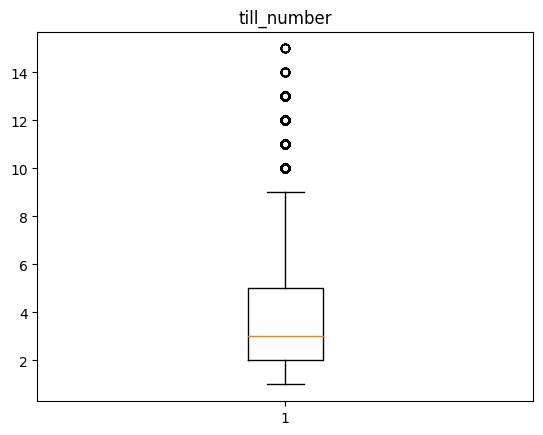

count    36279.000000
mean         3.638331
std          2.370963
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         15.000000
Name: till_number, dtype: float64


In [11]:
# Load the receipts data
receipts = pd.read_csv('receipts.csv')

# Check for outliers in the till_number column
plt.boxplot(receipts['till_number'])
plt.title('till_number')
plt.show()

# Check the descriptive statistics for till_number
print(receipts['till_number'].describe())

In [12]:
# Create lagged features for the input window (t-3 to t-1)
df['age_lag1'] = df.groupby('customer_id')['age'].shift(1)
df['age_lag2'] = df.groupby('customer_id')['age'].shift(2)
df['age_lag3'] = df.groupby('customer_id')['age'].shift

In [13]:
# Calculate the last purchase date for each customer and store combination
last_purchase_dates = df.groupby(['customer_id', 'store_code'])['purchased_at'].max().reset_index()

# Calculate the number of days since the last purchase
last_purchase_dates['days_since_last_purchase'] = (pd.Timestamp('now') - last_purchase_dates['purchased_at']).dt.days

# Create a churned variable where 1 indicates the customer has churned and 0 indicates the customer has not churned
last_purchase_dates['churned'] = last_purchase_dates['days_since_last_purchase'] > 90
last_purchase_dates['churned'] = last_purchase_dates['churned'].astype(int)

# Merge the churned variable with the main dataframe
df = pd.merge(df, last_purchase_dates[['customer_id', 'store_code', 'churned']], on=['customer_id', 'store_code'], how='left')

In [14]:
print(df.dtypes)

customer_id                            int64
first                                 object
last                                  object
dob                           datetime64[ns]
churned_x                              int64
receipt_id                             int64
purchased_at                  datetime64[ns]
store_code                             int64
till_number                            int64
receipt_line_id                        int64
product_code                           int64
qty                                    int64
value                                float64
address                               object
postcode                              object
lat                                  float64
lng                                  float64
product_details                       object
department_code                        int64
department_name                       object
category_code                         object
category_details                      object
sub_catego

**The Logistic Regression Model**

In [15]:
# Select the features and target variable
features = ['age', 'avg_purchase_value', 'months_since_last_purchase', 'monthly_purchase_frequency', 'num_visits', 'visit_share']
target = 'churned_x'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


# Impute missing values in the training set using mean imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Train a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict the target variable on the testing set
X_test = imputer.transform(X_test)
y_pred = clf.predict(X_test)



# Predict the target variable on the testing set
y_pred = clf.predict(X_test)

# Print the value of the coefficient for the first feature
beta = clf.coef_[0][0]
print('Beta:', beta)

# Evaluate the model's performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Beta: -0.001992451683468049
Accuracy: 0.7604273137920802
Precision: 0.7403420435801719
Recall: 0.42493397777667047
F1 score: 0.5399518804609346
ROC AUC: 0.6756220308947902


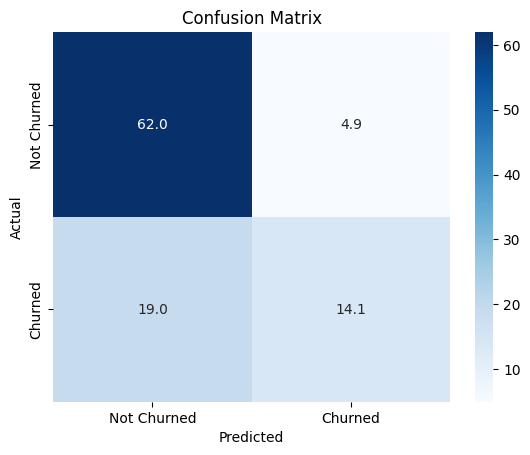

In [16]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Extract the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Define the confusion matrix
confusion_matrix = [[TN, FP], [FN, TP]]

# Calculate percentages for each cell in the confusion matrix
total = sum(sum(confusion_matrix, []))
confusion_matrix_percentages = [[100*value/total for value in row] for row in confusion_matrix]

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_percentages, annot=True, cmap='Blues', fmt='.1f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.yticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.show()


**The Random Forest Model**

In [17]:
# Select the features and target variable
features = ['age', 'avg_purchase_value', 'months_since_last_purchase', 'monthly_purchase_frequency', 'num_visits', 'visit_share']
target = 'churned_x'

# Drop any rows with missing values
df.dropna(inplace=True)

# Split the data into training and test sets
train_data = df.loc[:800, features]
train_target = df.loc[:800, target]
test_data = df.loc[800:, features]
test_target = df.loc[800:, target]

# Impute missing values in the training and test sets
imputer = SimpleImputer()
train_data_imputed = imputer.fit_transform(train_data)
test_data_imputed = imputer.transform(test_data)

# Train a random forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(train_data_imputed, train_target)

# Make predictions on the test set
y_pred = model.predict(test_data_imputed)

# Print classification report
print(classification_report(test_target, y_pred))

# Calculate and print accuracy score
print("Accuracy:", accuracy_score(test_target, y_pred))

# Calculate and print ROC AUC score
y_pred_proba = model.predict_proba(test_data_imputed)[:, 1]
print("ROC AUC score:", roc_auc_score(test_target, y_pred_proba))


              precision    recall  f1-score   support

           0       0.65      0.69      0.67        95
           1       0.33      0.29      0.30        49

    accuracy                           0.56       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.54      0.56      0.55       144

Accuracy: 0.5555555555555556
ROC AUC score: 0.47894736842105257


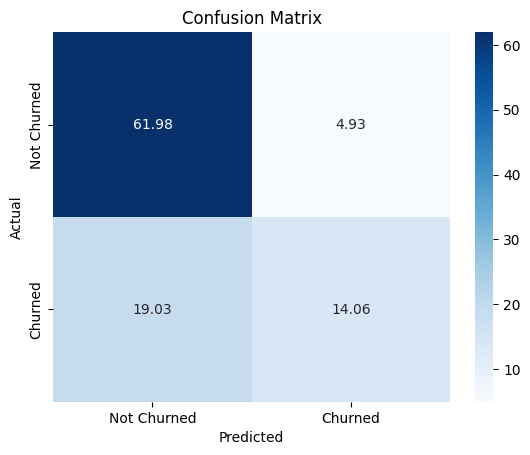

In [18]:
# Calculate the confusion matrix
cm2 = confusion_matrix(test_target, y_pred)
# Extract the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Define the confusion matrix
confusion_matrix = [[TN, FP], [FN, TP]]

# Calculate percentages for each cell in the confusion matrix
total = np.sum(confusion_matrix)
confusion_matrix_percentages = [[100*value/total for value in row] for row in confusion_matrix]

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_percentages, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.yticks([0.5, 1.5], ['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.show()



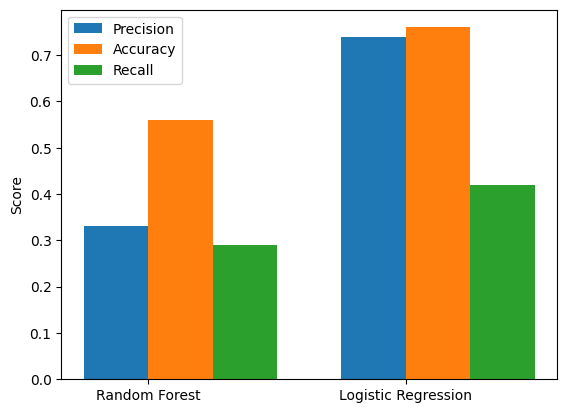

In [19]:
# Define the metrics for each model
rf_precision = 0.33
rf_accuracy = 0.56
rf_recall = 0.29

lr_precision = 0.74
lr_accuracy = 0.76
lr_recall = 0.42

# Create a bar plot
labels = ['Random Forest', 'Logistic Regression']
precision = [rf_precision, lr_precision]
accuracy = [rf_accuracy, lr_accuracy]
recall = [rf_recall, lr_recall]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, accuracy, width, label='Accuracy')
rects3 = ax.bar(x + width*1.5, recall, width, label='Recall')

ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [31]:
# Define the hyperparameters and their values for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create an instance of the model to be tuned
clf = LogisticRegression()

# Create a grid search object and fit it to the training data
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best hyperparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy score:  0.7619883702745767


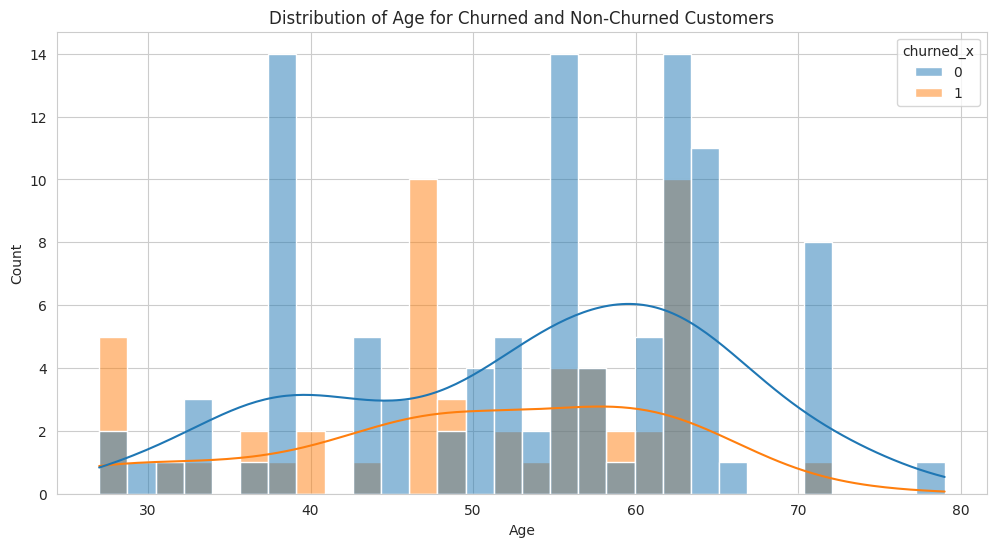

In [20]:

# Set up the plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the distributions of age for churned and non-churned customers
sns.histplot(data=df, x='age', hue='churned_x', bins=30, kde=True, alpha=0.5)

# Set the plot title and axis labels
ax.set_title('Distribution of Age for Churned and Non-Churned Customers')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

# Show the plot
plt.show()

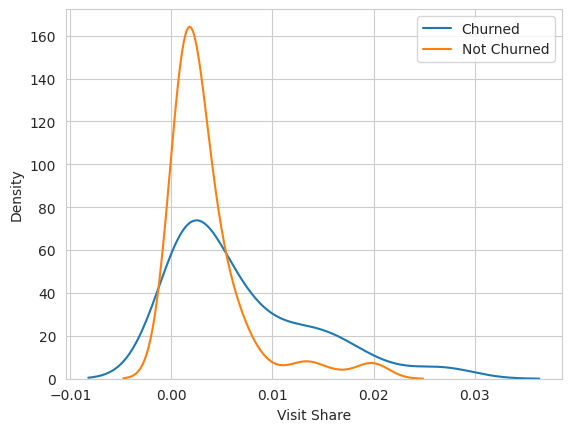

In [21]:
# Plot the visit share distribution for churned and non-churned customers
churned_x = df[df['churned_x'] == 1]
not_churned = df[df['churned_x'] == 0]

sns.kdeplot(churned_x['visit_share'], label='Churned')
sns.kdeplot(not_churned['visit_share'], label='Not Churned')
plt.xlabel('Visit Share')
plt.ylabel('Density')
plt.legend()


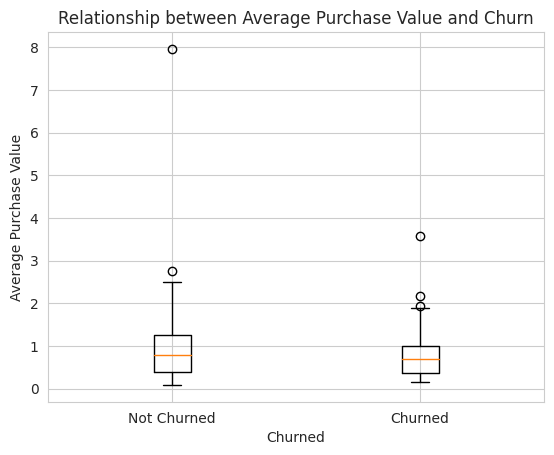

In [22]:
churned = df.loc[df['churned_x'] == 1, 'avg_purchase_value']
not_churned = df.loc[df['churned_x'] == 0, 'avg_purchase_value']

plt.boxplot([not_churned, churned], labels=['Not Churned', 'Churned'])
plt.xlabel('Churned')
plt.ylabel('Average Purchase Value')
plt.title('Relationship between Average Purchase Value and Churn')
plt.show()

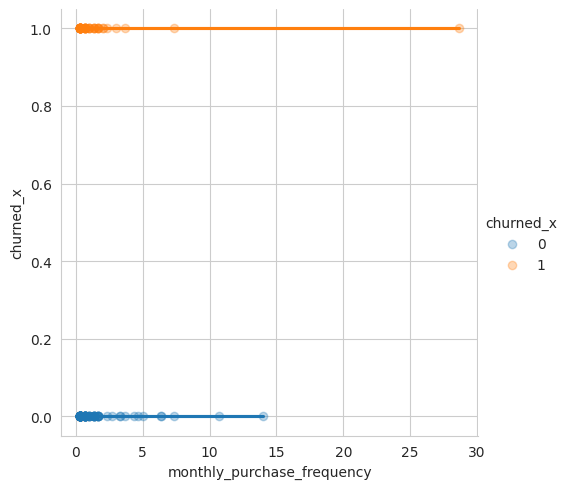

In [23]:
sns.lmplot(x="monthly_purchase_frequency", y="churned_x", data=df, hue="churned_x", scatter_kws={'alpha':0.3})
plt.show()

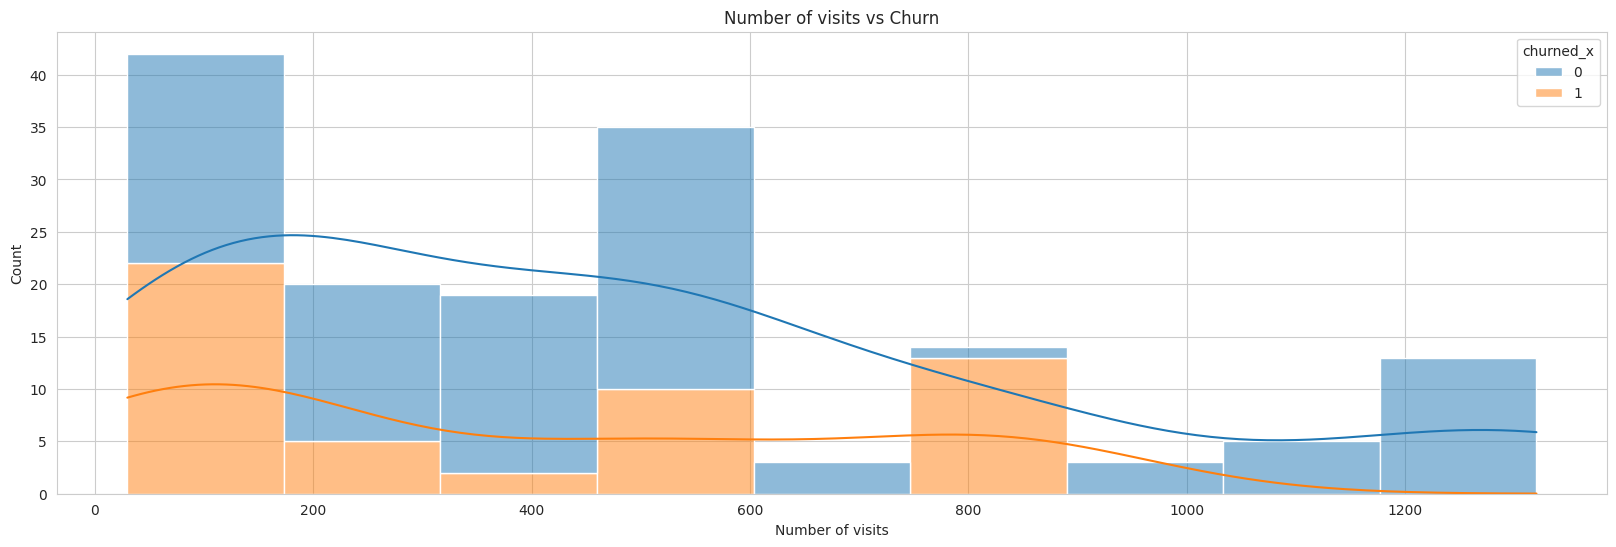

In [24]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x="num_visits", hue="churned_x", multiple="stack", kde=True)
plt.title("Number of visits vs Churn")
plt.xlabel("Number of visits")
plt.ylabel("Count")
plt.show()